In [1]:
#Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 15.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric import seed_everything
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
import torch.nn as nn


In [3]:
RANDOM_STATE = 42
seed_everything(RANDOM_STATE)

In [4]:
#ESTO ES PARA EJECUTAR EN COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Ruta donde guardaste el archivo gpickle
ruta_guardado = '/content/drive/My Drive/Colab Notebooks/GRAFO RETO/grafo.pkl'

# Carga el grafo desde el archivo gpickle
with open(ruta_guardado, 'rb') as file:
    G7 = pickle.load(file)

In [6]:
#Numero de features
features=list(G7.nodes(data=True))[0][1]
print(features)
num_features = len(features['feature'])
print('Numero de atributos:',num_features)

{'feature': [7, 'B11730', 'warm', 1.1, 'Formal', 1, 'smooth', 'street', 'tight', 'freetime'], 'label': 0}
Numero de atributos: 10


In [25]:
def obtener_datos_grafo(G):
  nodos = list(G.nodes)
  conexion = list(G.edges)
  caracteristicas_nodos = [G.nodes[nodo] for nodo in nodos]

  df_caracteristicas_nodos = pd.DataFrame(caracteristicas_nodos, index=nodos)
  caracteristicas_df = df_caracteristicas_nodos['feature'].apply(pd.Series)
  caracteristicas_df.columns = ['season','color','weather','subnivel','formalidad','adventurous','estampado','estilo','fit','application']

  df_caracteristicas_nodos = pd.concat([df_caracteristicas_nodos.drop(columns=['feature']), caracteristicas_df], axis=1)
  df_caracteristicas_nodos = df_caracteristicas_nodos.drop(columns=['season'])
  df_caracteristicas_nodos = df_caracteristicas_nodos.astype(str)

  categoricas = df_caracteristicas_nodos.columns
  categoricas = categoricas[categoricas != 'label']

  df_codificado = pd.get_dummies(df_caracteristicas_nodos, columns=categoricas)
  columnas = df_codificado.columns
  df_codificado[columnas] = df_codificado[columnas].astype(int)

  x_tensor = torch.tensor(df_codificado.drop(columns=['label']).values, dtype=torch.float32)

  edges=list(G7.edges)
  edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

  G7_data=Data(x=x_tensor, edge_index=edge_index)

  return G7_data,df_caracteristicas_nodos,df_codificado,x_tensor,edge_index

In [26]:
G7_data,df_caracteristicas_nodos,df_codificado,x_tensor,edge_index = obtener_datos_grafo(G7)
G7_data

Data(x=[1923, 94], edge_index=[2, 150028])

In [10]:
def receptive_field(G, node, k):
    """Calcula el receptive field de un nodo en k capas."""
    return set(nx.single_source_shortest_path_length(G, node, cutoff=k).keys())

def receptive_field_length_mean(G, max_k):
    """
    Calcula la media de la longitud del receptive field en el grafo para cada valor de k.

    Args:
        G: Grafo en formato NetworkX.
        max_k: Máximo número de capas (saltos) a considerar.

    Returns:
        dict: Media de la longitud del receptive field para cada k.
    """
    mean_lengths = {}

    for k in range(1, max_k + 1):
        lengths = []
        for node in G.nodes:
            # Obtener el receptive field usando BFS
            receptive_field = set(nx.single_source_shortest_path_length(G, node, cutoff=k).keys())
            lengths.append(len(receptive_field))

        # Calcular la media de las longitudes para el valor de k
        mean_lengths[k] = sum(lengths) / len(lengths)

    return mean_lengths

mean_lengths = receptive_field_length_mean(G7, max_k=3)

# Imprimir los resultados
print("Media de longitudes del receptive field por número de capas:")
for k, mean_length in mean_lengths.items():
  print(f"- {k} capas: {mean_length:.2f} nodos")


Media de longitudes del receptive field por número de capas:
- 1 capas: 157.04 nodos
- 2 capas: 1642.93 nodos
- 3 capas: 1907.00 nodos


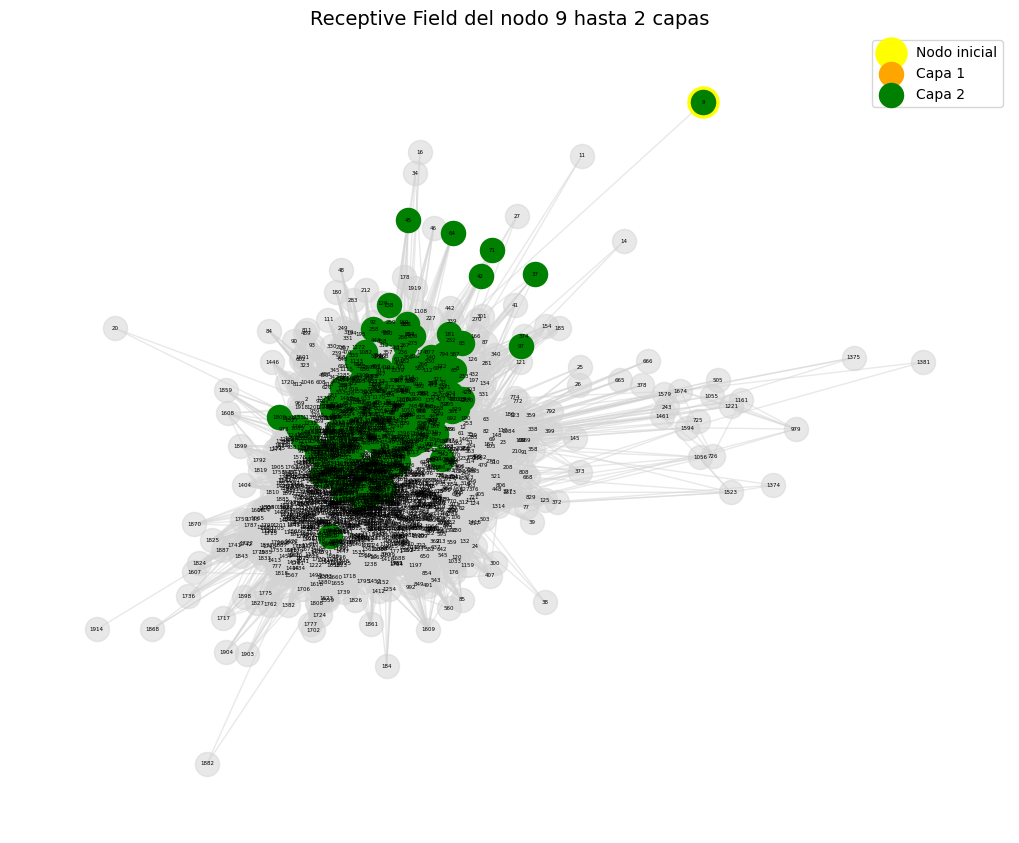

In [11]:
def plot_receptive_field(G, node, max_k):
    """
    Grafica el receptive field de un nodo en un grafo para cada capa hasta max_k.

    Args:
        G (networkx.Graph): Grafo en el que se calculará y graficará el receptive field.
        node (int/str): Nodo inicial.
        max_k (int): Número máximo de capas a considerar.

    Returns:
        None
    """
    # Posiciones para los nodos en el grafo
    pos = nx.spring_layout(G)  # Distribución visual del grafo
    plt.figure(figsize=(10, 8))

    # Dibujar el grafo completo en gris como fondo
    nx.draw(G, pos, node_color="lightgray", edge_color="lightgray", with_labels=False, alpha=0.5)

    # Dibujar las etiquetas con un tamaño de fuente reducido
    labels = {n: str(n) for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=4)

    # Colores para las capas
    colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

    # Dibujar el nodo inicial
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='yellow', label="Nodo inicial", node_size=500)

    # Graficar los receptive fields capa por capa
    for k in range(1, max_k + 1):
        # Calcular los nodos alcanzables en la capa k
        nodes_in_layer = receptive_field(G, node, k)

        # Dibujar los nodos alcanzables en esta capa
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes_in_layer,
            node_color=colors[k % len(colors)],
            label=f'Capa {k}',
            node_size=300
        )

    # Agregar título y leyenda
    plt.title(f"Receptive Field del nodo {node} hasta {max_k} capas", fontsize=14)
    plt.legend(scatterpoints=1)
    plt.show()

# Nodo inicial y número máximo de capas
start_node = 9
max_k = 2

# Graficar el receptive field del nodo inicial
plot_receptive_field(G7, start_node, max_k)


In [12]:
# Realizar el split de datos fuera del bucle
split = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
    edge_types=[0]
)
train_data, val_data, test_data = split(G7_data)

In [13]:
print('train_data: ', train_data)
print('val_data: ', val_data)
print('test_data: ', test_data)

train_data:  Data(x=[1923, 94], edge_index=[2, 255050], edge_label=[127525], edge_label_index=[2, 127525])
val_data:  Data(x=[1923, 94], edge_index=[2, 255050], edge_label=[15002], edge_label_index=[2, 15002])
test_data:  Data(x=[1923, 94], edge_index=[2, 270052], edge_label=[30004], edge_label_index=[2, 30004])


## GNN con mejoras

In [14]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_skip=True):
        super().__init__()

        # Indicador para usar skip connections
        self.use_skip = use_skip

        # Capas de preprocesamiento (MLP Layers)
        self.pre_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )

        #
        self.project_to_final_dim = torch.nn.Linear(64, 32)

        # Capas GNN principales
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.3)

        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

        # Capas de postprocesamiento (MLP Layers)
        self.post_mlp = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def encode(self, x, edge_index):
        # Preprocesamiento
        x_initial = self.pre_mlp(x) # Entrada inicial para skip connections

        # Primera capa con Batch Normalization
        x = self.conv1(x_initial, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        # Skip connection (entrada inicial sumada a la salida de la capa 1)
        if self.use_skip:
            x = x + x_initial

        x_initial_2 = x  # Guardar salida intermedia para la siguiente conexión residual

        # Segunda capa con Batch Normalization
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()

        # Skip connection (salida de la primera capa sumada a la salida final)
        if self.use_skip:
            x_initial_2 = self.project_to_final_dim(x_initial_2)
            x = x + x_initial_2

        return x

    def decode(self,z,edge_label_index):
      return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def obtener_links(self, z, edge_label_index,umbral):
        links_positivos=[]
        print((z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1))
        result= (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1).sigmoid()
        print(result)
        for i in range(len(result)):
            if result[i]>umbral:
                links_positivos.append(edge_label_index.t()[i])
        return links_positivos


MODELO GAT


In [16]:
class GatNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        # Primera capa GAT
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=False)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch Normalization
        self.dropout = torch.nn.Dropout(p=0.3)  # Regularización con dropout

        # Segunda capa GAT
        self.gat2 = GATConv(hidden_channels, out_channels, heads=heads, concat=False)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)  # Batch Normalization

    def encode(self, x, edge_index):

        # Primera capa GAT
        x = self.gat1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = self.dropout(x)  # Dropout
        x = x.relu()  # ReLU después de Dropout

        # Segunda capa GAT
        x = self.gat2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization

        return x

    def decode(self,z,edge_label_index):
      return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def obtener_links(self, z, edge_label_index,umbral):
        links_positivos=[]
        print((z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1))
        result= (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1).sigmoid()
        print(result)
        for i in range(len(result)):
            if result[i]>umbral:
                links_positivos.append(edge_label_index.t()[i])
        return links_positivos


MODELO GRAPHSAGE

In [17]:
class SageNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Primera capa GraphSAGE
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch Normalization
        self.dropout = torch.nn.Dropout(p=0.3)  # Regularización con dropout

        # Segunda capa GraphSAGE
        self.sage2 = SAGEConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)  # Batch Normalization

    def encode(self, x, edge_index):


        # Primera capa GraphSAGE
        x = self.sage1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = self.dropout(x)  # Dropout
        x = x.relu()  # ReLU después de Dropout

        # Segunda capa GraphSAGE
        x = self.sage2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization

        return x

    def decode(self,z,edge_label_index):
      return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def obtener_links(self, z, edge_label_index,umbral):
        links_positivos=[]
        print((z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1))
        result= (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1).sigmoid()
        print(result)
        for i in range(len(result)):
            if result[i]>umbral:
                links_positivos.append(edge_label_index.t()[i])
        return links_positivos





Funcion entrenamiento

In [18]:
def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=200,patience=50):

    best_val_auc = 0.0
    epochs_without_improvement = 0
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Obtener representaciones latentes de nodos
        z = model.encode(train_data.x, train_data.edge_index)

        # Muestreo de negativos dinámicos en cada época
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        # Concatenar positivos y negativos para entrenamiento
        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Predicción y cálculo de pérdida
        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")


        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch} as there is no improvement in validation AUC.")
            break

    return model


@torch.no_grad()
def eval_link_predictor(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


PRUEBA DIFERENTES HIPERPARAMETROS

GCN

In [ ]:
def hyperparameter_search(train_data, val_data, num_features):
    results = []  # Para almacenar los resultados de cada combinación

    learning_rates = [0.1, 0.01, 0.001]
    layers = [(64,32)]

    for layer in layers:
      for lr in learning_rates:
        print('Layers:', layer, 'Learning Rate:', lr)
        model = Net(G7_data.num_features, hidden_channels = layer[0], out_channels = layer[1])
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Entrenamiento del modelo
        model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

        # Evaluación del modelo en el conjunto de prueba
        val_auc = eval_link_predictor(model, val_data)
        test_auc = eval_link_predictor(model, test_data)

        # Registrar los resultados
        result = {'Layers': layer, 'Learning Rate': lr, 'Val AUC': val_auc,'Test AUC':test_auc}
        results.append(result)

        # Ordenar resultados por AUC de validación
        results = sorted(results, key=lambda x: x['Val AUC'], reverse=True)

    # Mostrar la mejor combinación
    best_result = results[0]
    print(f"Best combination: lr={best_result['Learning Rate']}, layers={best_result['Layers']} with val_auc={best_result['Val AUC']}")

    return results

results = hyperparameter_search(train_data, val_data, G7_data.num_features)


Layers: (64, 32) Learning Rate: 0.1
Epoch: 010, Train Loss: 2.975, Val AUC: 0.623
Epoch: 020, Train Loss: 1.055, Val AUC: 0.386
Epoch: 030, Train Loss: 0.943, Val AUC: 0.446
Epoch: 040, Train Loss: 0.725, Val AUC: 0.440
Epoch: 050, Train Loss: 0.702, Val AUC: 0.767
Epoch: 060, Train Loss: 0.698, Val AUC: 0.760
Epoch: 070, Train Loss: 0.696, Val AUC: 0.770
Epoch: 080, Train Loss: 0.697, Val AUC: 0.500
Epoch: 090, Train Loss: 0.695, Val AUC: 0.500
Epoch: 100, Train Loss: 0.692, Val AUC: 0.500
Epoch: 110, Train Loss: 0.694, Val AUC: 0.500
Early stopping at epoch 116 as there is no improvement in validation AUC.
Layers: (64, 32) Learning Rate: 0.01
Epoch: 010, Train Loss: 1.106, Val AUC: 0.331
Epoch: 020, Train Loss: 0.747, Val AUC: 0.589
Epoch: 030, Train Loss: 0.654, Val AUC: 0.725
Epoch: 040, Train Loss: 0.608, Val AUC: 0.800
Epoch: 050, Train Loss: 0.586, Val AUC: 0.825
Epoch: 060, Train Loss: 0.576, Val AUC: 0.839
Epoch: 070, Train Loss: 0.563, Val AUC: 0.850
Epoch: 080, Train Loss: 0

In [ ]:
results

[{'Layers': (64, 32),
  'Learning Rate': 0.01,
  'Val AUC': 0.8808047919522832,
  'Test AUC': 0.8815135829287553},
 {'Layers': (64, 32),
  'Learning Rate': 0.001,
  'Val AUC': 0.6955503297689446,
  'Test AUC': 0.6917038111311862},
 {'Layers': (64, 32), 'Learning Rate': 0.1, 'Val AUC': 0.5, 'Test AUC': 0.5}]

Best combination: lr=0.01, layers=(64, 32) with test_auc=0.8815135829287553

OPTIMIZACION GAT

In [ ]:
import torch
from itertools import product
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

def hyperparameter_search(train_data, val_data, num_features):
    results = []

    layers = [(64, 32), (128, 64)]
    learning_rates = [0.1, 0.01, 0.001]

    for layer in layers:
      for lr in learning_rates:
        print('Layers:', layer, 'Learning Rate:', lr)

        model_gat = GatNet(num_features, hidden_channels=layer[0], out_channels=layer[1])

        optimizer = torch.optim.Adam(params=model_gat.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        trained_model = train_link_predictor(model_gat, train_data, val_data, optimizer, criterion)

        val_auc = eval_link_predictor(trained_model, val_data)
        test_auc = eval_link_predictor(trained_model, test_data)

        results.append({
            'lr': lr,
            'hidden_channels': layer[0],
            'out_channels': layer[1],
            'val_auc': val_auc,
            'test_auc': test_auc
        })

    results = sorted(results, key=lambda x: x['val_auc'], reverse=True)

    best_result = results[0]
    print(f"Best combination: lr={best_result['lr']}, hidden_channels={best_result['hidden_channels']}, out_channels={best_result['out_channels']} with val_auc={best_result['val_auc']}")

    return results

results_gat = hyperparameter_search(train_data, val_data, G7_data.num_features)


Layers: (64, 32) Learning Rate: 0.1
Epoch: 010, Train Loss: 0.729, Val AUC: 0.566
Epoch: 020, Train Loss: 0.740, Val AUC: 0.574
Epoch: 030, Train Loss: 0.728, Val AUC: 0.551
Epoch: 040, Train Loss: 0.693, Val AUC: 0.548
Epoch: 050, Train Loss: 0.693, Val AUC: 0.549
Epoch: 060, Train Loss: 0.685, Val AUC: 0.591
Epoch: 070, Train Loss: 0.681, Val AUC: 0.608
Early stopping at epoch 74 as there is no improvement in validation AUC.
Layers: (64, 32) Learning Rate: 0.01
Epoch: 010, Train Loss: 1.000, Val AUC: 0.569
Epoch: 020, Train Loss: 0.802, Val AUC: 0.653
Epoch: 030, Train Loss: 0.739, Val AUC: 0.685
Epoch: 040, Train Loss: 0.715, Val AUC: 0.709
Epoch: 050, Train Loss: 0.695, Val AUC: 0.738
Epoch: 060, Train Loss: 0.675, Val AUC: 0.740
Epoch: 070, Train Loss: 0.647, Val AUC: 0.757
Epoch: 080, Train Loss: 0.659, Val AUC: 0.754
Epoch: 090, Train Loss: 0.648, Val AUC: 0.773
Epoch: 100, Train Loss: 0.625, Val AUC: 0.780
Epoch: 110, Train Loss: 0.631, Val AUC: 0.782
Epoch: 120, Train Loss: 0.

In [ ]:
results_gat

[{'lr': 0.01,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.8072211355688059,
  'test_auc': 0.8181272937327416},
 {'lr': 0.01,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.7924718423092183,
  'test_auc': 0.8024630778021313},
 {'lr': 0.001,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.7900499281960378,
  'test_auc': 0.7975035004442637},
 {'lr': 0.001,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.7627576421797273,
  'test_auc': 0.7745311645866673},
 {'lr': 0.1,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.6153254222816064,
  'test_auc': 0.6127558208876598},
 {'lr': 0.1,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.6042392054698444,
  'test_auc': 0.611598471756892}]

Best combination: lr=0.01, hidden_channels=128, out_channels=64 with test_auc=0.8080812795151289

OPTIMIZACION SAGE

Best combination: lr=0.01, hidden_channels=128, out_channels=64 with val_auc=0.8181272937327416

In [ ]:
import torch
from itertools import product
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

def hyperparameter_search(train_data, val_data, num_features):
    results = []

    layers = [(64, 32), (128, 64)]
    learning_rates = [0.1, 0.01, 0.001]

    for layer in layers:
      for lr in learning_rates:
        print('Layers:', layer, 'Learning Rate:', lr)

        model_sage = SageNet(num_features, hidden_channels=layer[0], out_channels=layer[1])

        optimizer = torch.optim.Adam(params=model_sage.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        trained_model = train_link_predictor(model_sage, train_data, val_data, optimizer, criterion)

        val_auc = eval_link_predictor(trained_model, val_data)
        test_auc = eval_link_predictor(trained_model, test_data)

        results.append({
            'lr': lr,
            'hidden_channels': layer[0],
            'out_channels': layer[1],
            'val_auc': val_auc,
            'test_auc':test_auc
        })

    results = sorted(results, key=lambda x: x['val_auc'], reverse=True)

    best_result = results[0]
    print(f"Best combination: lr={best_result['lr']}, hidden_channels={best_result['hidden_channels']}, out_channels={best_result['out_channels']} with val_auc={best_result['val_auc']}")

    return results

results_sage = hyperparameter_search(train_data, val_data, G7_data.num_features)


Layers: (64, 32) Learning Rate: 0.1
Epoch: 010, Train Loss: 0.699, Val AUC: 0.537
Epoch: 020, Train Loss: 0.680, Val AUC: 0.610
Epoch: 030, Train Loss: 0.672, Val AUC: 0.646
Epoch: 040, Train Loss: 0.651, Val AUC: 0.683
Epoch: 050, Train Loss: 0.644, Val AUC: 0.711
Epoch: 060, Train Loss: 0.639, Val AUC: 0.716
Epoch: 070, Train Loss: 0.632, Val AUC: 0.726
Epoch: 080, Train Loss: 0.627, Val AUC: 0.738
Epoch: 090, Train Loss: 0.619, Val AUC: 0.746
Epoch: 100, Train Loss: 0.617, Val AUC: 0.753
Epoch: 110, Train Loss: 0.610, Val AUC: 0.757
Epoch: 120, Train Loss: 0.604, Val AUC: 0.763
Epoch: 130, Train Loss: 0.600, Val AUC: 0.769
Epoch: 140, Train Loss: 0.595, Val AUC: 0.773
Epoch: 150, Train Loss: 0.591, Val AUC: 0.780
Epoch: 160, Train Loss: 0.588, Val AUC: 0.785
Epoch: 170, Train Loss: 0.587, Val AUC: 0.791
Epoch: 180, Train Loss: 0.585, Val AUC: 0.797
Epoch: 190, Train Loss: 0.580, Val AUC: 0.798
Epoch: 200, Train Loss: 0.581, Val AUC: 0.799
Layers: (64, 32) Learning Rate: 0.01
Epoch: 

In [ ]:
results_sage

[{'lr': 0.01,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.8536368638827536,
  'test_auc': 0.8587887543981383},
 {'lr': 0.01,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.8464994517639839,
  'test_auc': 0.849754359286335},
 {'lr': 0.001,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.8254771025419514,
  'test_auc': 0.8296562013746344},
 {'lr': 0.001,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.8085286091081737,
  'test_auc': 0.8138057217843113},
 {'lr': 0.1,
  'hidden_channels': 64,
  'out_channels': 32,
  'val_auc': 0.7986796356761817,
  'test_auc': 0.8059268251856959},
 {'lr': 0.1,
  'hidden_channels': 128,
  'out_channels': 64,
  'val_auc': 0.7693630717255298,
  'test_auc': 0.775602285602021}]

Best combination: lr=0.01, hidden_channels=128, out_channels=64 with val_auc=0.8587887543981383

Mejor modelo: lr=0.01, layers=(64, 32) with test_auc=0.9007, modelo = GCN

In [19]:
model = Net(G7_data.num_features, 64, 32)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion,n_epochs=300)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 1.047, Val AUC: 0.240
Epoch: 020, Train Loss: 0.740, Val AUC: 0.451
Epoch: 030, Train Loss: 0.653, Val AUC: 0.730
Epoch: 040, Train Loss: 0.611, Val AUC: 0.805
Epoch: 050, Train Loss: 0.589, Val AUC: 0.827
Epoch: 060, Train Loss: 0.577, Val AUC: 0.836
Epoch: 070, Train Loss: 0.564, Val AUC: 0.837
Epoch: 080, Train Loss: 0.558, Val AUC: 0.834
Epoch: 090, Train Loss: 0.550, Val AUC: 0.840
Epoch: 100, Train Loss: 0.545, Val AUC: 0.843
Epoch: 110, Train Loss: 0.538, Val AUC: 0.846
Epoch: 120, Train Loss: 0.535, Val AUC: 0.846
Epoch: 130, Train Loss: 0.531, Val AUC: 0.854
Epoch: 140, Train Loss: 0.525, Val AUC: 0.861
Epoch: 150, Train Loss: 0.522, Val AUC: 0.864
Epoch: 160, Train Loss: 0.520, Val AUC: 0.868
Epoch: 170, Train Loss: 0.517, Val AUC: 0.873
Epoch: 180, Train Loss: 0.514, Val AUC: 0.875
Epoch: 190, Train Loss: 0.509, Val AUC: 0.874
Epoch: 200, Train Loss: 0.508, Val AUC: 0.868
Epoch: 210, Train Loss: 0.506, Val AUC: 0.874
Epoch: 220, Train Loss: 0.505, Val

Guardar mejor modelo en pkl

In [20]:
torch.save(model,'/content/drive/My Drive/Colab Notebooks/GRAFO RETO/model.pth')

Cargar modelo entrenado

In [21]:
modelo = torch.load('/content/drive/My Drive/Colab Notebooks/GRAFO RETO/model.pth')

<ipython-input-21-563972512d88>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo = torch.load('/content/drive/My Drive/Colab Notebooks/GRAFO RETO/model.pth')


Guardar embeddings iniciales

In [22]:
embeddings_iniciales = modelo.encode(G7_data.x, G7_data.edge_index)
embeddings_iniciales

tensor([[  0.7298,   0.1338,   0.5968,  ...,   0.7183,   0.5713,  -0.5880],
        [ -0.6372,  -0.7744,  -0.4053,  ...,  -0.4437,  -0.8543,   2.7812],
        [ -0.2346,  -0.0929,  -0.4845,  ...,   2.9328,  -0.8212,   3.2524],
        ...,
        [  1.2791,  -3.9009,   2.7048,  ...,  -8.5214,   6.0169,  12.1292],
        [  5.7222,  -1.7728,   5.7949,  ..., -13.2190,   5.9593,  28.6768],
        [  2.2817,  -2.6831,   3.8088,  ...,  28.2668,  -8.6165,  39.1918]],
       grad_fn=<AddBackward0>)




### Crear nueva prenda

In [23]:
def obtener_prenda_nueva(df_caracteristicas_nodos,df_codificado):
    valores_aleatorios = {col: np.random.choice(df_caracteristicas_nodos[col]) for col in df_caracteristicas_nodos.columns if col != 'label'}

    nuevo_label = int(df_caracteristicas_nodos['label'].iloc[-1]) + 1
    valores_aleatorios['label'] = nuevo_label

    df_caracteristicas_prenda_nueva = pd.DataFrame([valores_aleatorios])
    df_caracteristicas_nodos_nuevo = pd.concat([df_caracteristicas_nodos, df_caracteristicas_prenda_nueva], ignore_index=True)
    dummies_prenda_nueva = pd.get_dummies(df_caracteristicas_prenda_nueva, dtype=int)
    columnas_categoricas = df_codificado.columns
    columnas_categoricas = df_codificado.columns[columnas_categoricas != 'label']
    dummies_prenda_nueva = dummies_prenda_nueva.reindex(columns=columnas_categoricas,fill_value=0)
    caracteristicas_prenda_nueva_tensor=torch.tensor(dummies_prenda_nueva.values, dtype=torch.float32)

    return df_caracteristicas_prenda_nueva,df_caracteristicas_nodos_nuevo,caracteristicas_prenda_nueva_tensor


In [27]:
df_caracteristicas_prenda_nueva,df_caracteristicas_nodos_nuevo,caracteristicas_prenda_nueva_tensor = obtener_prenda_nueva(df_caracteristicas_nodos,df_codificado)

In [28]:
nodo_nuevo = df_caracteristicas_prenda_nueva['label'].item()
nodo_nuevo

1923

In [29]:
def calcular_similitud(node1, node2,df_caracteristicas_nodos_nuevo):
      row1 = df_caracteristicas_nodos_nuevo.loc[int(node1)]
      row2 = df_caracteristicas_nodos_nuevo.loc[int(node2)]

      temperatura_map = {'cold': 0, 'warm': 1}
      temperatura_diff = abs(temperatura_map.get(row1.weather, -1) - temperatura_map.get(row2.weather, -1))

      formalidad_map = {'formal':1,'informal':0}
      formalidad_diff = abs(formalidad_map.get(row1.formalidad, -1) - formalidad_map.get(row2.formalidad, -1))

      adventurous_diff = abs(int(row1.adventurous) - int(row2.adventurous)) / (5 - 1)

      feature_diff = np.array([
      adventurous_diff,
      temperatura_diff,
      formalidad_diff
      ])
      similaridad = feature_diff.sum()

      if row1.color == row2.color:
        similaridad += 0
      else:
        similaridad += 1

      if row1.estampado == row2.estampado:
        similaridad += 0
      else:
        similaridad += 1

      if row1.estilo == row2.estilo:
        similaridad += 0
      else:
        similaridad += 1

      if row1.fit == row2.fit:
        similaridad += 0
      else:
        similaridad += 1

      if row1.application == row2.application:
        similaridad += 0
      else:
        similaridad += 1

      return similaridad

In [30]:
def encontrar_nodo_mas_similar(nodo_inicial, df_caracteristicas_nodos_nuevo):
    caracteristicas_nodo_objetivo = df_caracteristicas_nodos_nuevo.loc[nodo_inicial]
    subnivel = caracteristicas_nodo_objetivo['subnivel']
    df = df_caracteristicas_nodos_nuevo[df_caracteristicas_nodos_nuevo['subnivel'] == subnivel]
    nodos = df['label'].unique()
    nodo_mas_similar = None
    similitud_minima = float('inf')
    for nodo in nodos:
        if int(nodo) != int(nodo_inicial):  # No comparar el nodo consigo mismo
            similitud = calcular_similitud(nodo_inicial, nodo, df_caracteristicas_nodos_nuevo)
            if similitud < similitud_minima:
                similitud_minima = similitud
                nodo_mas_similar = nodo

    return nodo_mas_similar, similitud_minima

In [31]:
nodo_mas_similar,similitud_minima = encontrar_nodo_mas_similar(nodo_nuevo,df_caracteristicas_nodos_nuevo)
print(f'El nodo mas similar al nodo {nodo_nuevo} es el nodo {nodo_mas_similar}')

El nodo mas similar al nodo 1923 es el nodo 285


In [32]:
x_tensor_combinado = torch.cat([G7_data.x, caracteristicas_prenda_nueva_tensor], dim=0)
x_tensor_combinado.shape

torch.Size([1924, 94])

In [33]:
conexiones_nodo_mas_similar = list(G7.neighbors(int(nodo_mas_similar)))
len(conexiones_nodo_mas_similar)

62

In [34]:
indices_conexiones_prenda_nueva = torch.tensor([[int(nodo_nuevo), i] for i in conexiones_nodo_mas_similar], dtype=torch.long).t().contiguous()
indices_conexiones_prenda_nueva

tensor([[1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923,
         1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923,
         1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923,
         1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923,
         1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923, 1923,
         1923, 1923],
        [   3,    5,   10,   12,   15,   17,   19,   21,   28,   30,   35,   40,
           49,   53,   54,   55,   57,   61,   62,   67,   70,   76,   88,   94,
           95,  102,  108,  130,  136,  156,  157,  158,  159,  162,  164,  165,
          167,  170,  171,  179,  196,  200,  201,  202,  203,  204,  205,  218,
          221,  225,  230,  240,  241,  242,  256,  260,  264,  265,  272,  276,
          277,  279]])

In [35]:
edge_index_combinado = torch.cat([G7_data.edge_index, indices_conexiones_prenda_nueva], dim=-1)
edge_index_combinado

tensor([[   0,    0,    0,  ..., 1923, 1923, 1923],
        [  53,   68,   91,  ...,  276,  277,  279]])

In [36]:
modelo.eval()
nuevos_embeddings = modelo.encode(x_tensor_combinado,edge_index_combinado)
embedding_nuevo_nodo = nuevos_embeddings[-1]
embedding_nuevo_nodo = embedding_nuevo_nodo.unsqueeze(0)
embedding_nuevo_nodo

tensor([[-0.2232, -0.6177,  0.0069, -0.0902,  2.1793,  0.1390, -0.7197,  1.8269,
          0.2735,  0.4040,  0.1351,  0.2031,  1.5344,  0.1608,  2.5892, -0.9877,
          0.6240, -0.4313,  3.6089, -0.3299, -0.5884, -0.3626,  0.5970,  3.3019,
         -0.5628,  0.7226, -0.0607, -0.4637, -0.2585, -0.5472,  1.0419, -0.0374]],
       grad_fn=<UnsqueezeBackward0>)

In [37]:
embeddings_actualizados = torch.cat((embeddings_iniciales, embedding_nuevo_nodo), dim=0)
embeddings_actualizados.shape

torch.Size([1924, 32])

In [38]:
modelo.eval()
links_positivos = modelo.obtener_links(embeddings_actualizados,indices_conexiones_prenda_nueva,umbral=0.95)

tensor([17.5567, 19.5183, 26.7940, 36.6052, 11.9867,  5.9256, 28.1506, 20.1930,
         5.1641,  0.3957,  6.7892, 11.2216, 10.3983, 12.5340,  3.6977,  3.4850,
        11.3542, 35.7362, 11.6406, 13.3729, 10.2796, -0.7379,  8.0175, 11.6288,
        32.2036, -0.7379, 15.2891, 10.4029, 37.1141, -1.5370, 31.3408, 11.9014,
        -1.3115, 36.8486, 16.0796, 10.2289, 17.9173, 25.5574, 10.8677, -7.4741,
        13.9233, 13.9951, -2.7931, 39.5147, 14.6579, 25.1532, 10.9587, 35.6980,
         3.4768, 18.5403, 13.3230, 10.0087,  4.6962,  0.8333, 45.8569, 36.0371,
        47.5528, 14.1026, 27.3221, 20.8756,  8.0860,  6.9513],
       grad_fn=<SumBackward1>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9999e-01, 9.9734e-01,
        1.0000e+00, 1.0000e+00, 9.9431e-01, 5.9765e-01, 9.9888e-01, 9.9999e-01,
        9.9997e-01, 1.0000e+00, 9.7582e-01, 9.7026e-01, 9.9999e-01, 1.0000e+00,
        9.9999e-01, 1.0000e+00, 9.9997e-01, 3.2346e-01, 9.9967e-01, 9.9999e-01,
        1.0000e+00, 3.2346

In [43]:
vecinos_predichos = [int(link[1]) if link[0] == nodo_nuevo else int(link[0]) for link in links_positivos]
print(vecinos_predichos)

[3, 5, 10, 12, 15, 17, 19, 21, 28, 35, 40, 49, 53, 54, 55, 57, 61, 62, 67, 70, 88, 94, 95, 108, 130, 136, 157, 158, 162, 164, 165, 167, 170, 171, 196, 200, 202, 203, 204, 205, 218, 221, 225, 230, 240, 241, 256, 260, 264, 265, 272, 276, 277, 279]
